<a href="https://colab.research.google.com/github/MufiOktaviani/age-classification-by-voice/blob/main/Age_Classification_by_Voice_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Module

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [ ]:
 !pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.8 MB/s eta 0:00:00


In [ ]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# Other
import librosa
import librosa.display
import json
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import seaborn as sns
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook
import sys
import warnings
# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
!pip install numpy scipy
!pip install resampy tensorflow six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 45.1 MB/s eta 0:00:00


In [ ]:
import resampy

#Augmentation Methods

In [ ]:
# Augmentation methods
def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)

def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())
    data = librosa.effects.pitch_shift(data.astype('float64'), sample_rate, n_steps=pitch_change, bins_per_octave=bins_per_octave)
    return data

def dyn_change(data):
    dyn_change = np.random.uniform(low=-0.05 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)

def speedNpitch(data):
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

##Explore Data Augmentation

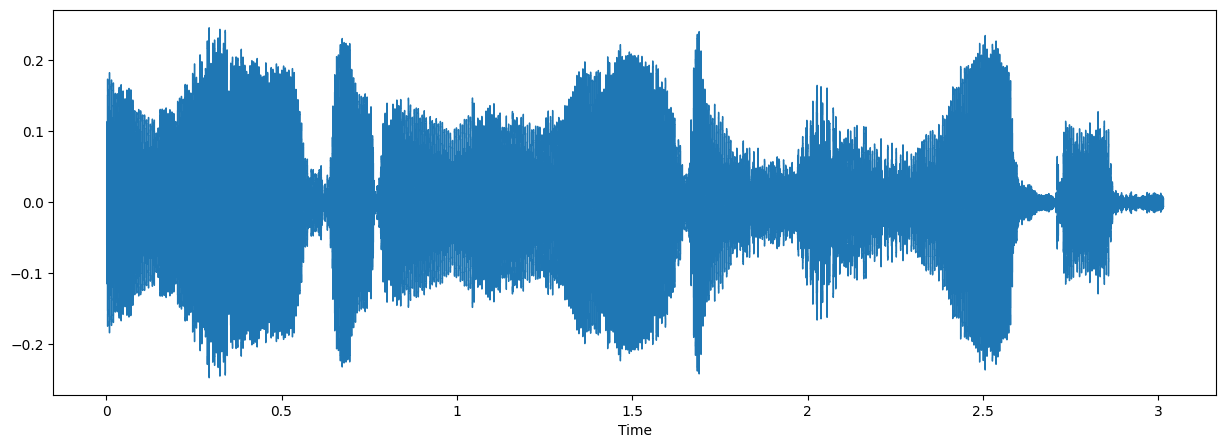

In [ ]:
fname = '/content/drive/MyDrive/Data Set Voice/Kn- (123).wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Paly it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

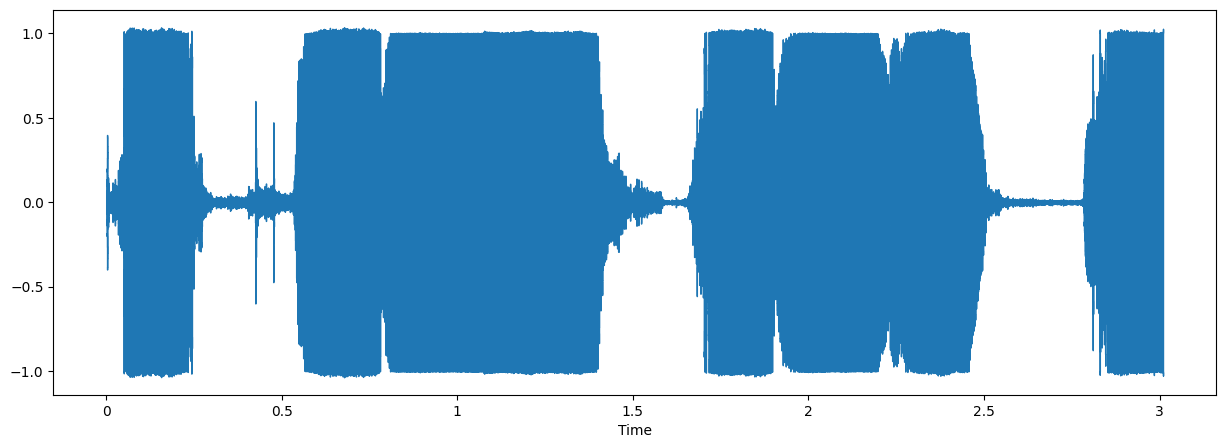

In [ ]:
fname = '/content/drive/MyDrive/Data Set Voice/EFn- (99).wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Play it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

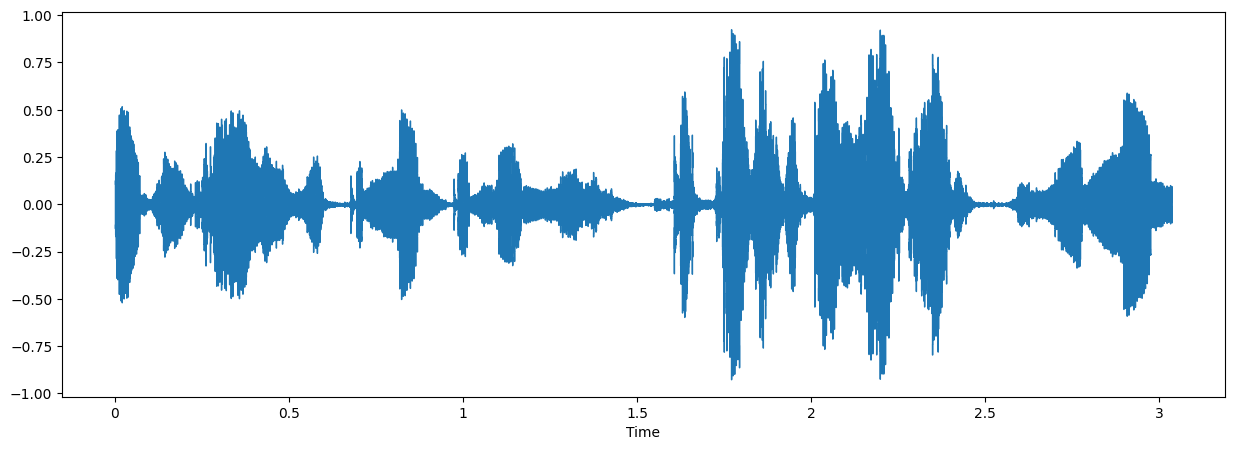

In [ ]:
fname = '/content/drive/MyDrive/Data Set Voice/MFn- (99).wav'
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

# Play it again to refresh our memory
ipd.Audio(data, rate=sampling_rate)

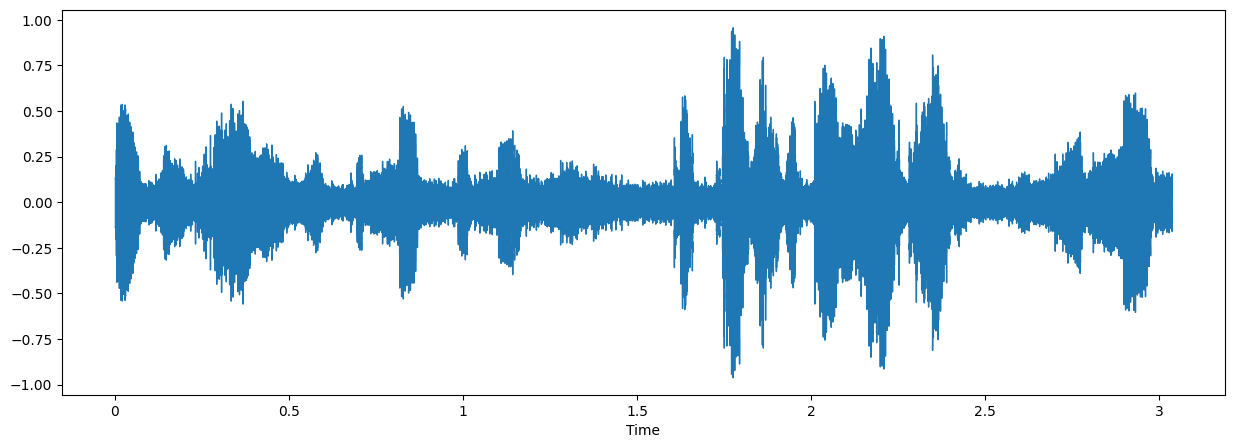

In [ ]:
#static noise
x = noise(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

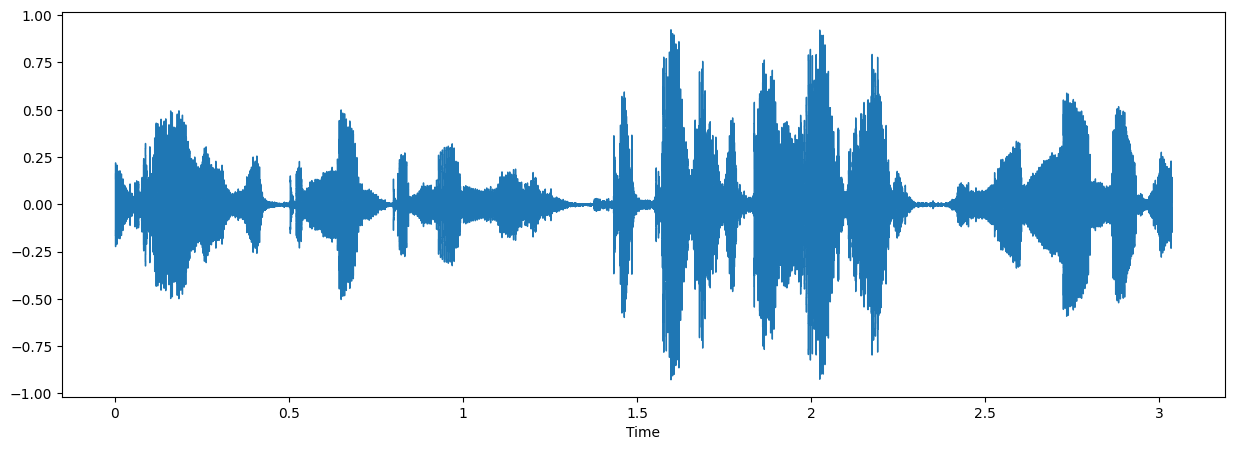

In [ ]:
#shift method
x = shift(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

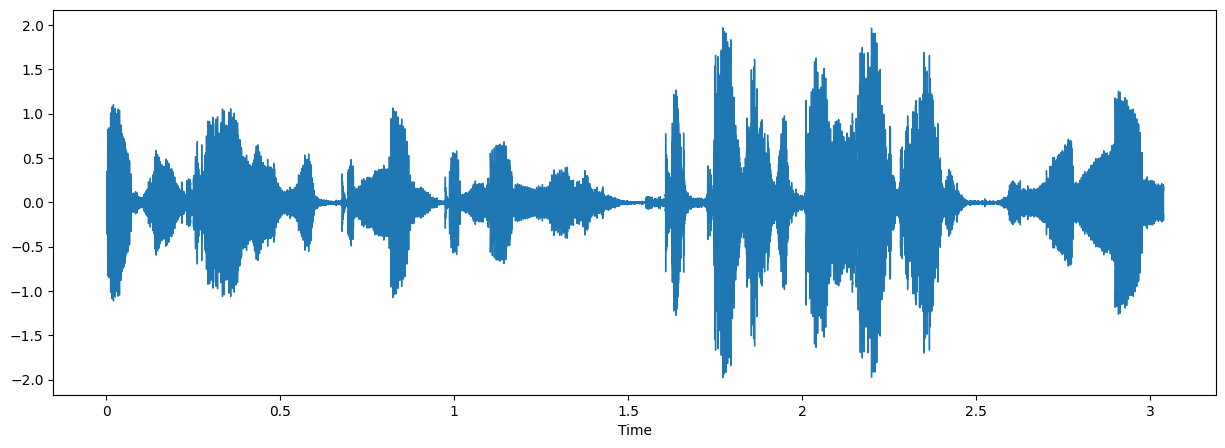

In [ ]:
#dynamic change
x = dyn_change(data)
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sampling_rate)
ipd.Audio(x, rate=sampling_rate)

#Data Preparation and processing

In [ ]:
audios=['Kn-','MMn-', 'MFn-','EMn-','EFn-']
for audio in audios:
    sound_files=glob.glob('/content/drive/MyDrive/Data Set Voice/'+audio+'*.wav')
    print('processing %d audios in %s file... '% (len(sound_files), audio))

processing 300 audios in Kn- file... 
processing 300 audios in MMn- file... 
processing 300 audios in MFn- file... 
processing 300 audios in EMn- file... 
processing 300 audios in EFn- file... 


In [ ]:
age_gender = '/content/drive/MyDrive/Data Set Voice/'
dir_list = os.listdir(age_gender)
dir_list.sort()
dir_list[0:7]

['EFn- (1).wav',
 'EFn- (10).wav',
 'EFn- (100).wav',
 'EFn- (101).wav',
 'EFn- (102).wav',
 'EFn- (103).wav',
 'EFn- (104).wav']

In [ ]:
#Label data
AG =[]
path = []
for i in dir_list:
    if i[0:4]=='Kn- ':
        AG.append('Kids')
    elif i[0:5]=='MMn- ':
        AG.append('Middle_Age')
    elif i[0:5]=='MFn- ':
        AG.append('Middle_Age')
    elif i[0:5]=='EMn- ':
        AG.append('Elderly_Age')
    elif i[0:5]=='EFn- ':
        AG.append('Elderly_Age')
    else:
        AG.append('agegander_error')
    path.append(age_gender + i)

In [ ]:
age_gender_df = pd.DataFrame(AG, columns = ['labels'])
age_gender_df['source'] = 'age_gender'
age_gender_df = pd.concat([age_gender_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
age_gender_df.labels.value_counts()

Elderly_Age    600
Middle_Age     600
Kids           300
Name: labels, dtype: int64

In [ ]:
#save data wav to csv
df = pd.concat([age_gender_df], axis = 0)
print(df.labels.value_counts())
df.head()
df.to_csv("Voice-age.csv",index=False)

Elderly_Age    600
Middle_Age     600
Kids           300
Name: labels, dtype: int64


In [ ]:
ref = pd.read_csv("./Voice-age.csv")
ref.head()

,labels,source,path
0,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (1)...
1,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...
2,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...
3,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...
4,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...


In [ ]:
# Augmentation data
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_shift = pd.DataFrame(columns=['feature'])
df_dyn_change = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):

    # first load the audio
    X, sample_rate = librosa.load(i, res_type='kaiser_fast',duration=2.5,sr=44100,offset=0.5)

    # take mfcc and mean as the feature. Could do min and max etc as well.
    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=np.array(sample_rate),n_mfcc=13),axis=0)
    df.loc[cnt] = [mfccs]

    # noise
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug,sr=np.array(sample_rate),n_mfcc=13),axis=0)
    df_noise.loc[cnt] = [aug]

    # shift method (random)
    aug = shift(X)
    aug = np.mean(librosa.feature.mfcc(y=aug,sr=np.array(sample_rate),n_mfcc=13),axis=0)
    df_shift.loc[cnt] = [aug]

    # dynamic change
    aug = dyn_change(X)
    aug = np.mean(librosa.feature.mfcc(y=aug,sr=np.array(sample_rate),n_mfcc=13),axis=0)
    df_dyn_change.loc[cnt] = [aug]

    cnt += 1

df.head()

100%|██████████| 1500/1500 [05:07<00:00,  4.89it/s]


,feature
0,"[-13.054918, -11.808335, -11.655335, -11.79182..."
1,"[-8.603927, -7.633273, -9.475657, -8.931934, -..."
2,"[7.0150065, 4.863513, 1.1526685, 1.275449, 2.7..."
3,"[-17.535625, -13.362993, -11.197222, -11.76325..."
4,"[-23.554506, -20.89409, -21.290579, -23.815134..."


In [ ]:
# combine
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_shift = pd.concat([ref,pd.DataFrame(df_shift['feature'].values.tolist())],axis=1)
df_dyn_change = pd.concat([ref,pd.DataFrame(df_dyn_change['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_shift.shape,df_dyn_change.shape)

(1500, 219) (1500, 219) (1500, 219) (1500, 219)


In [ ]:
df = pd.concat([df,df_noise,df_shift,df_dyn_change],axis=0,sort=False)
df=df.fillna(0)
del df_noise,df_shift,df_dyn_change

df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (1)...,-13.054918,-11.808335,-11.655335,-11.791821,-9.995956,-10.281855,-12.443584,...,-14.381219,-14.594290,-11.835621,-11.638432,-12.696462,-11.135397,-9.667869,-7.766192,-7.432380,-10.015505
1,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,-8.603927,-7.633273,-9.475657,-8.931934,-9.221889,-9.384957,-8.796293,...,-8.426289,-8.302672,-7.107274,-6.786587,-9.262034,-10.336020,-11.189940,-10.610833,0.000000,0.000000
2,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,7.015007,4.863513,1.152668,1.275449,2.757715,3.083710,2.503433,...,-11.803394,-14.383218,-16.214489,-16.853823,-16.011705,-18.055937,-18.908604,-18.797401,-18.514921,-16.164314
3,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,-17.535625,-13.362993,-11.197222,-11.763251,-5.161132,2.083721,3.119986,...,-1.739643,-2.296282,-3.240697,-5.329117,-10.557836,-9.628376,-9.931514,-11.081746,-4.306976,2.575388
4,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,-23.554506,-20.894091,-21.290579,-23.815134,-23.935284,-18.638933,-12.770789,...,1.678345,1.030523,-0.380742,-1.560566,-1.357918,-3.284723,-6.038879,6.918449,0.000000,0.000000


In [ ]:
# saving the dataframe
df.to_csv('age-aug.csv')

In [ ]:
import pandas as pd
df = pd.read_csv("./age-aug.csv", skiprows=0)
df = df.drop(df.columns[0], axis=1)
df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (1)...,-13.054918,-11.808335,-11.655335,-11.791821,-9.995956,-10.281855,-12.443584,...,-14.381219,-14.594290,-11.835621,-11.638432,-12.696462,-11.135397,-9.667869,-7.766192,-7.432380,-10.015505
1,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,-8.603927,-7.633273,-9.475657,-8.931934,-9.221889,-9.384957,-8.796293,...,-8.426289,-8.302672,-7.107274,-6.786587,-9.262034,-10.336020,-11.189940,-10.610833,0.000000,0.000000
2,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,7.015007,4.863513,1.152668,1.275449,2.757715,3.083710,2.503433,...,-11.803394,-14.383218,-16.214489,-16.853823,-16.011705,-18.055937,-18.908604,-18.797401,-18.514921,-16.164314
3,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,-17.535625,-13.362993,-11.197222,-11.763251,-5.161132,2.083721,3.119986,...,-1.739643,-2.296282,-3.240697,-5.329117,-10.557836,-9.628376,-9.931514,-11.081746,-4.306976,2.575388
4,Elderly_Age,age_gender,/content/drive/MyDrive/Data Set Voice/EFn- (10...,-23.554506,-20.894091,-21.290579,-23.815134,-23.935284,-18.638933,-12.770789,...,1.678345,1.030523,-0.380742,-1.560566,-1.357918,-3.284723,-6.038879,6.918449,0.000000,0.000000


In [ ]:
print(df.shape)

(6000, 219)


## Pembagian Dataset

In [ ]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels, test_size=0.25, shuffle=True, random_state=42)

# Lets see how the data present itself before normalisation
X_train[175:180]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
4819,13.691877,13.330314,12.655808,12.730957,12.006042,10.992016,10.111761,9.226686,7.038053,0.424831,...,9.139520,10.458291,10.627504,10.789124,10.024026,9.348818,7.470186,6.937742,8.159829,8.741949
3194,-9.399194,-4.869609,-6.192194,-6.225418,-9.524095,-13.325860,-12.603770,-12.612835,-12.061846,-12.008504,...,-6.752996,-4.697839,-2.653311,-4.203232,-6.172366,-7.551774,-4.714980,-3.649492,-4.177418,-4.866841
1230,3.925587,3.940979,0.857147,-0.313741,-2.563119,-3.182559,-2.259720,-2.545438,-0.318396,2.607103,...,3.300033,0.544893,0.472784,0.754469,-0.261087,2.645798,0.000000,0.000000,0.000000,0.000000
2760,-5.603254,-1.625444,2.726858,4.032222,3.767917,2.011808,0.856429,0.018385,-1.311631,-2.460371,...,-2.994768,-3.274987,-4.112265,-4.443162,-6.095003,-7.905299,-6.194386,-5.527451,-5.399495,-5.045506
5537,-8.187212,-9.305415,-13.425920,-16.099049,-20.199350,-20.481941,-21.421648,-20.883314,-18.880995,-15.846292,...,-34.995663,-32.357677,-31.822401,-32.062008,-30.518269,-28.867746,-29.300243,-32.519569,-27.930656,-21.725237



## Mean

In [ ]:
#score cross validation fix
data["SVM"], data["SVM"].mean()

(array([0.73333333, 0.77777778, 0.69777778, 0.74222222, 0.72444444,
        0.70222222, 0.76444444, 0.71333333, 0.73111111, 0.77555556]),
 0.7362222222222222)

## Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
svm = SVC(C=1, degree=2, gamma=0.1, kernel='poly')
scores = cross_val_score(svm, X_train, y_train, cv=10)
scores

array([0.73333333, 0.77777778, 0.69777778, 0.74222222, 0.72444444,
       0.70222222, 0.76444444, 0.71333333, 0.73111111, 0.77555556])

#Search Best Parameters Support Vector Machine

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  49.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  43.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  56.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=  46.6s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.3min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   2.1s
[CV] END .....................C=0.1, gamma=1, k

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001],'kernel': ['rbf', 'poly'],'degree':[1,2,3]}
grid = GridSearchCV(SVC(),param_grid,cv=10,refit=True)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

In [ ]:
print ("Parameter Terbaik: {}".format(grid.best_params_))
print ("Akurasi:{}".format(grid.best_score_))

Parameter Terbaik: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}
Akurasi:0.6328888888888888


## Confusion Matrix SVM

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [ ]:
svm = SVC(C=1, degree=2, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)

train_accuracy = svm.score(X_train, y_train)
print("Training Accuracy : ", train_accuracy)
test_accuracy = svm.score(X_test, y_test)
print("Testing Accuracy : ", test_accuracy)

Training Accuracy :  1.0
Testing Accuracy :  0.758


In [ ]:
svm = SVC(C=1, degree=2, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Akurasi : ', accuracy_score(y_test, y_pred))

[[502  43  81]
 [ 55 210  38]
 [ 97  49 425]]
              precision    recall  f1-score   support

 Elderly_Age       0.77      0.80      0.78       626
        Kids       0.70      0.69      0.69       303
  Middle_Age       0.78      0.74      0.76       571

    accuracy                           0.76      1500
   macro avg       0.75      0.75      0.75      1500
weighted avg       0.76      0.76      0.76      1500

Akurasi :  0.758


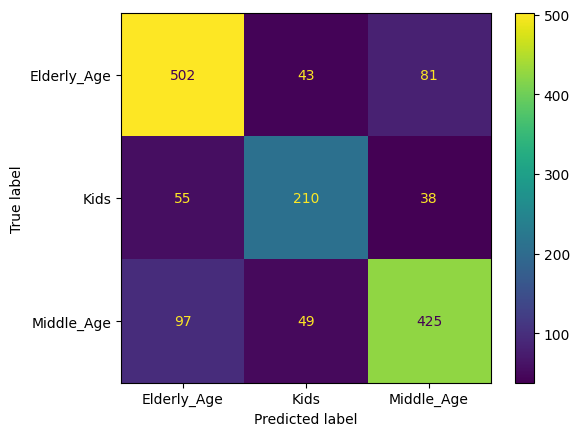

In [ ]:
svm = SVC(C=1, degree=2, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
SVC(C=1, degree=2, gamma=0.1, kernel='poly')
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

In [ ]:
svm = SVC(C=1, degree=0, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)

train_accuracy = svm.score(X_train, y_train)
print("Training Accuracy : ", train_accuracy)
test_accuracy = svm.score(X_test, y_test)
print("Testing Accuracy : ", test_accuracy)

Training Accuracy :  0.40644444444444444
Testing Accuracy :  0.38066666666666665


In [ ]:
svm = SVC(C=1, degree=0, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Akurasi : ', accuracy_score(y_test, y_pred))

[[  0   0 626]
 [  0   0 303]
 [  0   0 571]]
              precision    recall  f1-score   support

 Elderly_Age       0.00      0.00      0.00       626
        Kids       0.00      0.00      0.00       303
  Middle_Age       0.38      1.00      0.55       571

    accuracy                           0.38      1500
   macro avg       0.13      0.33      0.18      1500
weighted avg       0.14      0.38      0.21      1500

Akurasi :  0.38066666666666665


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


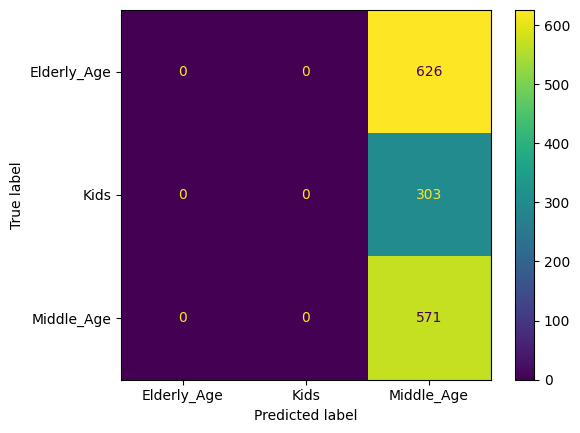

In [ ]:
svm = SVC(C=1, degree=0, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
SVC(C=1, degree=0, gamma=0.1, kernel='poly')
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

In [ ]:
svm = SVC(C=1, degree=1, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)

train_accuracy = svm.score(X_train, y_train)
print("Training Accuracy : ", train_accuracy)
test_accuracy = svm.score(X_test, y_test)
print("Testing Accuracy : ", test_accuracy)

Training Accuracy :  0.5982222222222222
Testing Accuracy :  0.5133333333333333


In [ ]:
svm = SVC(C=1, degree=1, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Akurasi : ', accuracy_score(y_test, y_pred))

[[370  60 196]
 [ 98  94 111]
 [206  59 306]]
              precision    recall  f1-score   support

 Elderly_Age       0.55      0.59      0.57       626
        Kids       0.44      0.31      0.36       303
  Middle_Age       0.50      0.54      0.52       571

    accuracy                           0.51      1500
   macro avg       0.50      0.48      0.48      1500
weighted avg       0.51      0.51      0.51      1500

Akurasi :  0.5133333333333333


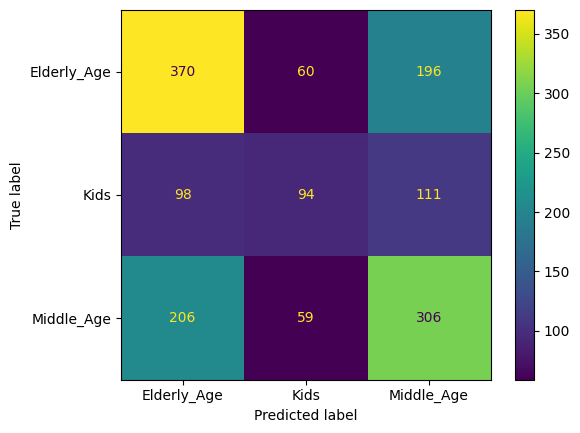

In [ ]:
svm = SVC(C=1, degree=1, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
SVC(C=1, degree=1, gamma=0.1, kernel='poly')
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

In [ ]:
svm = SVC(C=1, degree=3, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)

train_accuracy = svm.score(X_train, y_train)
print("Training Accuracy : ", train_accuracy)
test_accuracy = svm.score(X_test, y_test)
print("Testing Accuracy : ", test_accuracy)

Training Accuracy :  1.0
Testing Accuracy :  0.6593333333333333


In [ ]:
svm = SVC(C=1, degree=3, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Akurasi : ', accuracy_score(y_test, y_pred))

[[468  68  90]
 [ 67 189  47]
 [165  74 332]]
              precision    recall  f1-score   support

 Elderly_Age       0.67      0.75      0.71       626
        Kids       0.57      0.62      0.60       303
  Middle_Age       0.71      0.58      0.64       571

    accuracy                           0.66      1500
   macro avg       0.65      0.65      0.65      1500
weighted avg       0.66      0.66      0.66      1500

Akurasi :  0.6593333333333333


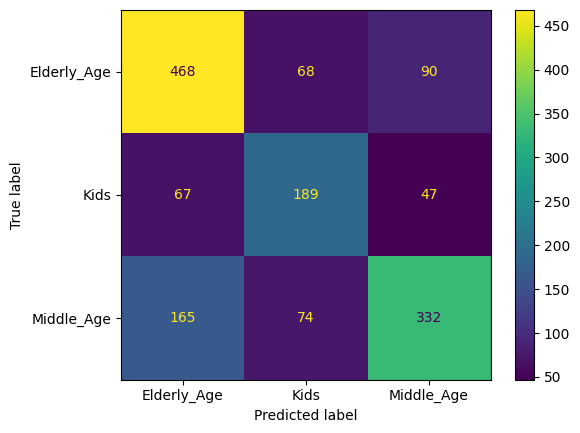

In [ ]:
svm = SVC(C=1, degree=3, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
SVC(C=1, degree=3, gamma=0.1, kernel='poly')
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()

In [ ]:
svm = SVC(C=1, degree=4, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)

train_accuracy = svm.score(X_train, y_train)
print("Training Accuracy : ", train_accuracy)
test_accuracy = svm.score(X_test, y_test)
print("Testing Accuracy : ", test_accuracy)

Training Accuracy :  1.0
Testing Accuracy :  0.6313333333333333


In [ ]:
svm = SVC(C=1, degree=4, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
sklearn.metrics.accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('Akurasi : ', accuracy_score(y_test, y_pred))

[[439  77 110]
 [ 81 173  49]
 [135 101 335]]
              precision    recall  f1-score   support

 Elderly_Age       0.67      0.70      0.69       626
        Kids       0.49      0.57      0.53       303
  Middle_Age       0.68      0.59      0.63       571

    accuracy                           0.63      1500
   macro avg       0.61      0.62      0.61      1500
weighted avg       0.64      0.63      0.63      1500

Akurasi :  0.6313333333333333


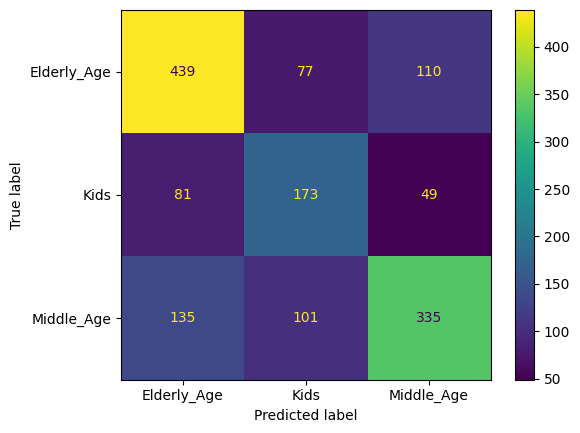

In [ ]:
svm = SVC(C=1, degree=4, gamma=0.1, kernel='poly')
svm.fit(X_train, y_train)
SVC(C=1, degree=4, gamma=0.1, kernel='poly')
predictions = svm.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=svm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
disp.plot()
plt.show()